In [1]:
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import operator
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imblearn.over_sampling as imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
nations = ['Italy','England','France','Spain','European_Championship','World_Cup']

events = {}
events['England'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_England.json')
events['Italy'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_Italy.json')
events['France'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_France.json')
events['Spain'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_Spain.json')
events['European_Championship'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_European_Championship.json')
events['World_Cup'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_World_Cup.json')

matches = {}
matches['England'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_England.json')
matches['Italy'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_Italy.json')
matches['France'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_France.json')
matches['Spain'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_Spain.json')
matches['European_Championship'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_European_Championship.json')
matches['World_Cup'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_World_Cup.json')

teams = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/teams.json')

stadiums = pd.read_excel('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/Stadium field dimensions formatted.xlsx')


In [3]:
Englandshots = events['England']['eventName'] == 'Shot'
shots = events['England'][Englandshots]
all_matches = matches['England']
nationsnoEng = ['Italy','France','Spain','European_Championship','World_Cup']

for nation in nationsnoEng:
    all_matches = pd.concat([all_matches, matches[nation]])
    shotsbool = events[nation]['eventName'] == 'Shot'
    onlyshots = events[nation][shotsbool]
    shots = pd.concat([shots, onlyshots])

In [4]:
shots['x'] = [x[0]['x'] for x in shots['positions']]
shots['y'] = [x[0]['y'] for x in shots['positions']]

In [5]:
players = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/players.json')

In [6]:
players['position'] = [x['name'] for x in players['role']]

In [7]:
playersprac = players[['firstName', 'lastName', 'height', 'weight', 'shortName', 'foot', 'wyId', 'position']]
shots = pd.merge(shots, playersprac, left_on = 'playerId', right_on = 'wyId')
len(shots)

36177

In [8]:
shots = shots[shots['position'] != 'Goalkeeper']

In [9]:
all_matches['Both_Teams'] = [tuple(x.keys()) for x in all_matches['teamsData']]

all_matches['Team1'] = [x[0] for x in all_matches['Both_Teams']]
all_matches['Team2'] = [x[1] for x in all_matches['Both_Teams']]

shots = pd.merge(shots, all_matches, left_on = 'matchId', right_on = 'wyId')

In [10]:
venues_formatted = []
for idx, row in shots.iterrows():
    if row['venue'] not in list(stadiums['Stadium']):
        venues_formatted.append('Default')
    else:
        venues_formatted.append(row['venue'])

In [11]:
shots['venues_formatted'] = venues_formatted

In [12]:
shots = pd.merge(shots, stadiums, left_on = 'venues_formatted', right_on = 'Stadium')
len(shots)

36174

In [13]:
#probably change this variable to distance_perc
shots['distanceperc'] = np.sqrt(np.power(shots["x"] - 100, 2) + np.power(shots["y"] - 50, 2))
#probably change this variable to distance_m
shots['distance_m'] = np.sqrt(np.power((0.01*shots["x"]*shots["Length"]) 
                                                  - shots["Length"], 2) + 
                                         np.power((0.01*shots["y"]*shots["Width"]) 
                                                  - (0.5*shots["Width"]), 2))

In [14]:
tagvalscol = []
for x in shots['tags']:
    tagvals = []
    for i in range(len(x)):
        tagvals.append(x[i]['id'])
    tagvalscol.append(tagvals)
shots['tagvals'] = tagvalscol

In [15]:
shots['goal'] = [1 if 101 in x else 0 for x in shots['tagvals']]

In [108]:
shots = pd.merge(shots, teams, left_on = 'teamId', right_on = 'wyId')

array([[<AxesSubplot:title={'center':'goal'}>]], dtype=object)

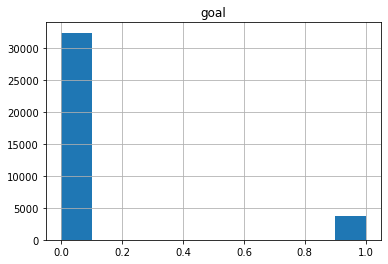

In [17]:
shots.hist('goal')

array([[<AxesSubplot:title={'center':'distance_m'}>]], dtype=object)

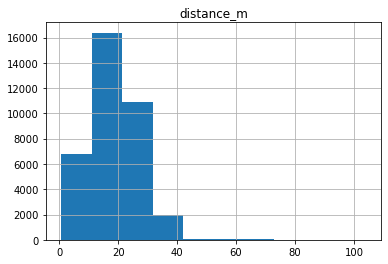

In [18]:
shots.hist('distance_m')

In [19]:
#add a column for the shot angle
#Looked at a few stadiums in Italy and they all had dimensions of 105*68m
angles = []
for idx, row in shots.iterrows():
    #If shooting from touchline, angle will be zero
    #continue to avoid divide by zero errors
    if row['x'] == 100:
        angles.append(0)
        continue
    #moving everything to left side of the field to make calculation easier
    if row['y'] > 50:
        mirror = 100 - row['y']
    else:
        mirror = row['y']
    #following four lines attempt to adjust to the actual field width and get 
    #more accurate positioning of the goal posts. e.g. Previously had right goal post at 
    #53.6 as opposed to most often at 54.64 which implicitly assumed width was 100 (which
    # is never the case). Thus, divide width by goal length to get percentage of field it takes up
    #and add half that percentage evenly to either side of 50
    goal_perc = (7.32/row['Width'])*100
    increment = goal_perc/2
    left_post = 50 - increment
    right_post = 50 + increment
    dist_a = ((row['x'] - 100)**(2))**(1/2)
    dist_b = ((mirror - right_post)**2)**(1/2)
    dist_c = ((mirror - left_post)**2)**(1/2)
    theta = np.arctan(dist_b/dist_a)*(180/math.pi)
    phi = np.arctan(dist_c/dist_a)*(180/math.pi)
    #Different cases for between the goalposts vs. to the left of a goalpost
    if mirror < left_post:
        angles.append(theta - phi)
    else:
        angles.append(theta + phi)
shots['angle'] = angles

array([[<AxesSubplot:title={'center':'angle'}>]], dtype=object)

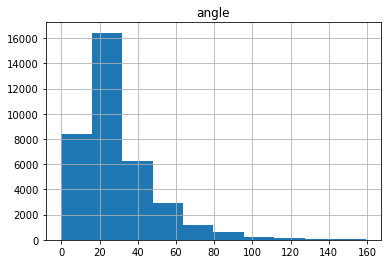

In [20]:
shots.hist('angle')

In [21]:
shots['foot_shot'] = ['right' if 402 in x else 'left' if 401 in x else 'head/body' for x in shots['tagvals']]

In [22]:
#1 means the player shot with their strong foot, 0 means they shot with their weak foot or
#with their head/body
strong_foot = []
header = []
for idx, row in shots.iterrows():
    if row['foot_shot'] == row['foot']:
        strong_foot.append(1)
    else:
        strong_foot.append(0)
    if row['foot_shot'] == 'head/body':
        header.append(1)
    else:
        header.append(0)

In [23]:
shots['strong_foot'] = strong_foot
shots['header'] = header

array([[<AxesSubplot:title={'center':'strong_foot'}>]], dtype=object)

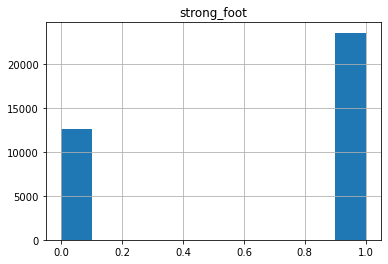

In [24]:
shots.hist('strong_foot')

In [25]:
print(len(shots[shots['strong_foot'] == 1]))
print(len(shots[shots['foot_shot'] == 'left']))
print(len(shots[shots['foot_shot'] == 'head/body']))

23585
11985
5847


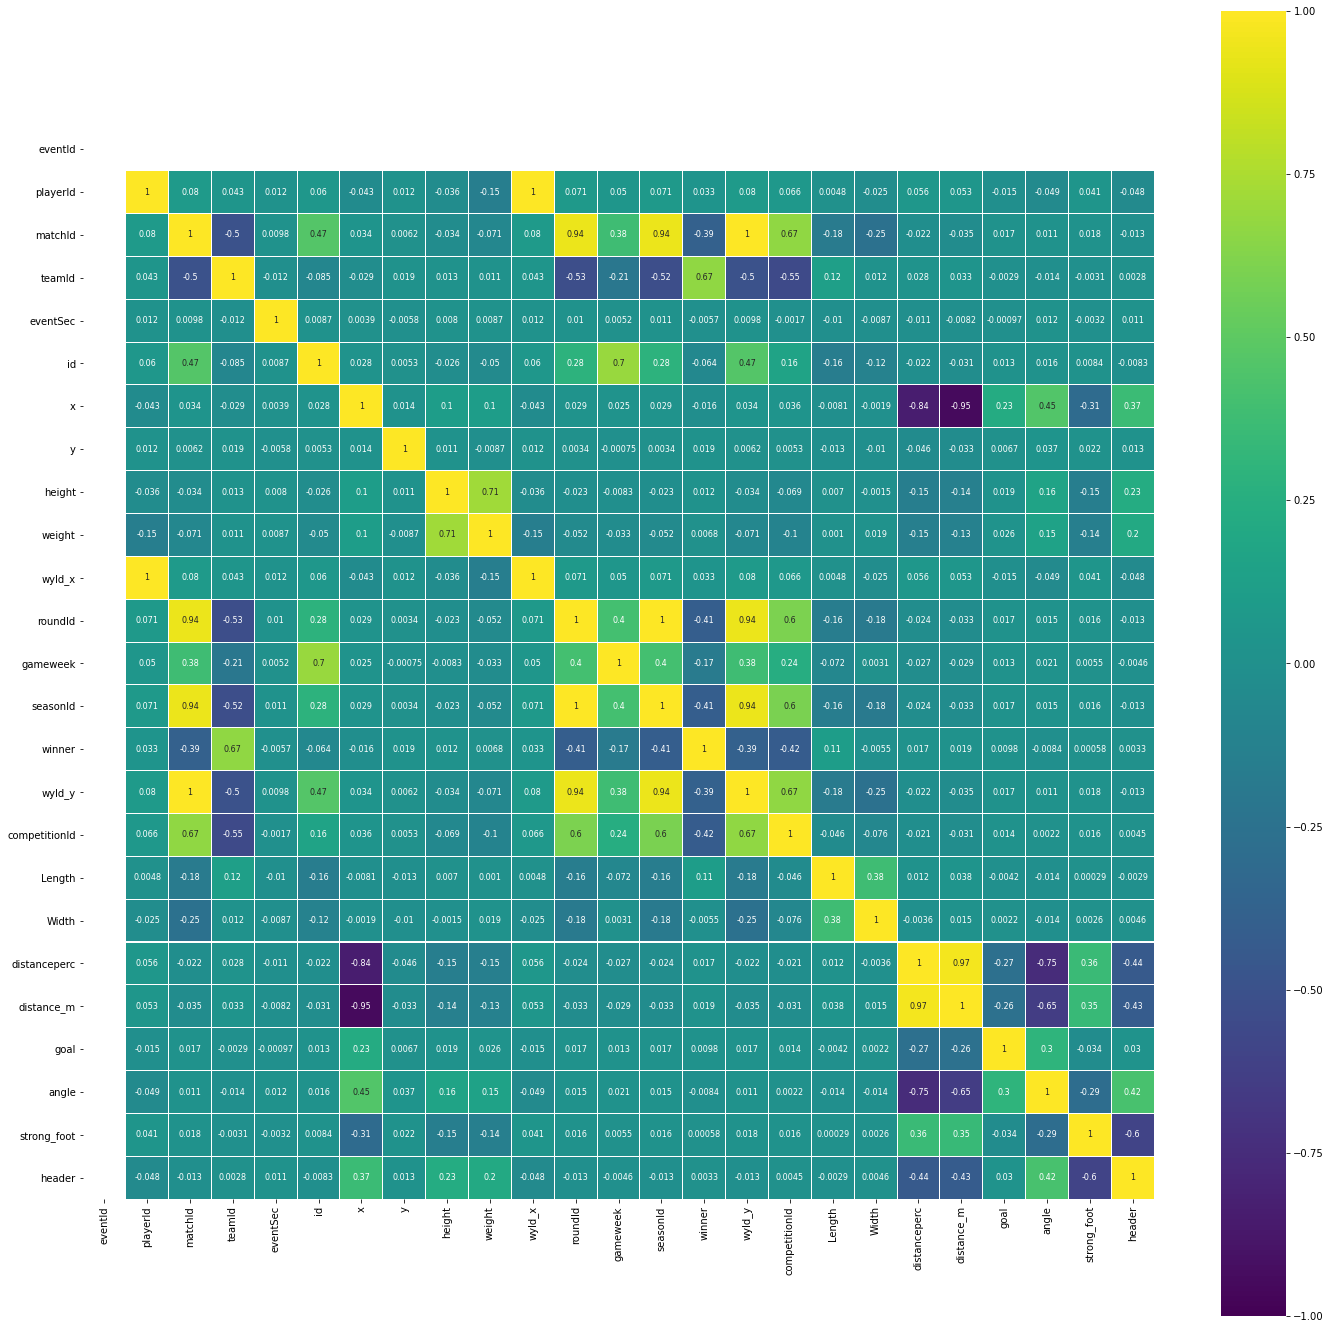

In [26]:
df_corr = shots.corr()
plt.figure(figsize=(24, 24))

sns.heatmap(df_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [27]:
#procedure for creating dummy variables is the same as in the below column, can actually add it into the same for loop
#that being said, would there be an issue for adding in only two observations with goalkeeper shots where one is a
#goal? Might the algorithm think its extremely likely for goalkeepers to score when they're shooting when in fact this
#is just because of how few observations we have of goalkeepers shooting? Because of course we assume Forwards are
#most likely to score. But also, is this largely just because they shoot from the most advanced positions, at least
#from the view of the dataset?
positions = ['Forward', 'Midfielder', 'Defender']
for pos in positions:
    pos_shots = shots[shots['position'] == pos]
    goalsfrompos = pos_shots[pos_shots['goal'] == 1]
    perc_goals = len(goalsfrompos)/len(pos_shots)
    print('The percentage of successful shots from the', pos, 'position in this database is: ', perc_goals)

The percentage of successful shots from the Forward position in this database is:  0.13472133247918
The percentage of successful shots from the Midfielder position in this database is:  0.08015292776175464
The percentage of successful shots from the Defender position in this database is:  0.078868258178603


In [28]:
forward = []
midfielder = []
defender = []
for idx, row in shots.iterrows():
    if row['position'] == 'Forward':
        forward.append(1)
        midfielder.append(0)
        defender.append(0)
    elif row['position'] == 'Midfielder':
        forward.append(0)
        midfielder.append(1)
        defender.append(0)
    else:
        forward.append(0)
        midfielder.append(0)
        defender.append(1)

In [29]:
shots['F'] = forward
shots['MF'] = midfielder
shots['DEF'] = defender

In [30]:
#Add 45*60 seconds to every event in the second half, as eventSec tracks the number of seconds since
#the start of the current half
eventTime = []
for idx, row in shots.iterrows():
    if row['matchPeriod'] == '2H':
        eventTime.append(row['eventSec'] + (45*60))
    else:
        eventTime.append(row['eventSec'])

In [31]:
shots['eventTime'] = eventTime

In [32]:
shots[['x', 'y', 'angle']]

,x,y,angle
0,88,41,33.383357
1,87,48,44.175016
2,90,34,18.219757
3,85,52,38.911535
4,92,50,67.864868
...,...,...,...
36169,91,45,51.512110
36170,76,59,22.360806
36171,92,46,59.350515
36172,96,58,40.157329


In [33]:
y = shots['goal']
#weakfoot is base case for what foot the shot is, defender is base case for position group
X = shots[['distance_m', 'angle']]
dummies = np.asarray(shots[['strong_foot', 'header']])

In [34]:
dummies

array([[1, 0],
       [1, 0],
       [0, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [35]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.append(X, dummies, axis = 1)

In [36]:
#should split before oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [37]:
# transform the dataset
oversample = imb.SMOTE(sampling_strategy = (1/2))
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [38]:
len(y_over[y_over == 1])/len(y_over)

0.3333242051647178

In [39]:
#Model fitted on untransformed dataset with apparently very low predictive power
xGmodel2 = LogisticRegression(random_state = 0).fit(X_train, y_train)
xGmodel2.coef_

array([[-1.07073488,  0.33275757,  0.16025815, -0.88050553]])

In [40]:
#accuracies of logistic regression on training, test set
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(xGmodel2.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xGmodel2.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.90
Accuracy of logistic regression classifier on test set: 0.90


In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_untrans_pred = xGmodel2.predict(X_test)
print(confusion_matrix(y_test, y_untrans_pred))
print(classification_report(y_test, y_untrans_pred))

[[8021   64]
 [ 860   99]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8085
           1       0.61      0.10      0.18       959

    accuracy                           0.90      9044
   macro avg       0.76      0.55      0.56      9044
weighted avg       0.87      0.90      0.86      9044



In [53]:
#This is the model fitted on the transformed dataset0
xGmodel = LogisticRegression(random_state=0).fit(X_over, y_over)

In [54]:
#see if I can use one of their earlier versions of the code to see how the coefficients have changed
#angle effect is much smaller by now
print(xGmodel.coef_)

[[-1.06544631  0.34147204  0.15233658 -0.90810501]]


In [55]:
y_pred_train = xGmodel.predict(X_train)
y_pred_test = xGmodel.predict(X_test)

In [56]:
print(len(y_pred_test))
print(len(y_pred_test[y_pred_test == 1]))

9044
1269


In [57]:
goalprobs = [x[1] for x in xGmodel.predict_proba(X_test)]
goalprobs = np.asarray(goalprobs)
len(goalprobs[goalprobs > 0.5])
#Classification such that if the model spits out a probability of scoring greater than 0.5, will be a goal

1269

In [58]:
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(xGmodel.score(X_over, y_over)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xGmodel.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.74
Accuracy of logistic regression classifier on test set: 0.84


In [59]:
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix_logistic)

[[7211  874]
 [ 564  395]]


In [60]:
#Reason for this confusion matrix--high accuracy but low recall and f1-score
num_goals = len(shots[shots['goal'] == 1])
num_misses = len(shots[shots['goal'] == 0])
perc_goals = num_goals/len(shots)
perc_misses = num_misses/len(shots)
print('Percentage of goals is: ', perc_goals)
print('Number of goals is', num_goals, ', number of misses is', num_misses)
#Attempt to use SMOTE and undersampling to rectify this
#SMOTE rather than normal oversampling

Percentage of goals is:  0.10349975120252115
Number of goals is 3744 , number of misses is 32430


In [61]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      8085
           1       0.31      0.41      0.35       959

    accuracy                           0.84      9044
   macro avg       0.62      0.65      0.63      9044
weighted avg       0.86      0.84      0.85      9044



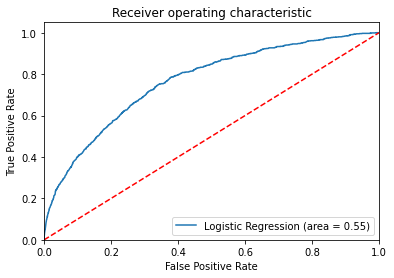

In [62]:
#ROC curve for untransformed dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, xGmodel2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xGmodel2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

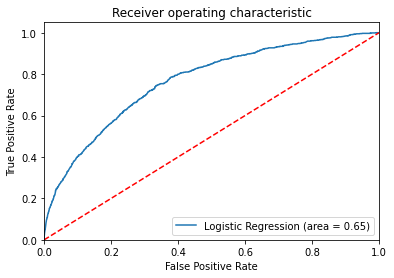

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, xGmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xGmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [64]:
print('F-Score for SMOTE model', f1_score(y_test, y_pred_test))
print('F-Score for untransformed model', f1_score(y_test, y_untrans_pred))

F-Score for SMOTE model 0.35457809694793535
F-Score for untransformed model 0.1764705882352941


In [65]:
#website for us to compare xG results with: https://understat.com/league/EPL/2017

In [66]:
#nontransformed dataset random forest
clf2 = RandomForestClassifier(random_state=0, oob_score = True, max_depth = 5, n_estimators = 500)
clf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, oob_score=True,
                       random_state=0)

In [67]:
y_pred_forest_train_2 = clf2.predict(X_train)
y_pred_forest_test_2 = clf2.predict(X_test)
print(clf2.feature_importances_)
print(classification_report(y_test, y_pred_forest_test_2))

[0.5673392  0.35150118 0.01767282 0.0634868 ]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      8085
           1       0.64      0.10      0.17       959

    accuracy                           0.90      9044
   macro avg       0.77      0.55      0.56      9044
weighted avg       0.88      0.90      0.86      9044



In [68]:
clf = RandomForestClassifier(random_state=0, oob_score = True, max_depth = 5, n_estimators = 500)
clf.fit(X_over, y_over)

RandomForestClassifier(max_depth=5, n_estimators=500, oob_score=True,
                       random_state=0)

In [69]:
y_pred_forest_train = clf.predict(X_train)
y_pred_forest_test = clf.predict(X_test)

In [70]:
#X = shots[['eventTime', 'distance_m', 'angle','strong_foot', 'header']]
clf.feature_importances_

array([0.59259086, 0.34168113, 0.01638415, 0.04934387])

In [71]:
print('Accuracy of random forest classifier on training set: {:.2f}'.format(clf.score(X_over, y_over)))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('OOB score of random forest classifier on training set: {:.2f}'.format(clf.oob_score_))
print('OOB score of random forest classifier on test set: {:.2f}'.format(clf.oob_score_))

Accuracy of random forest classifier on training set: 0.75
Accuracy of random forest classifier on test set: 0.84
OOB score of random forest classifier on training set: 0.75
OOB score of random forest classifier on test set: 0.75


In [72]:
print(classification_report(y_test, y_pred_forest_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      8085
           1       0.31      0.42      0.36       959

    accuracy                           0.84      9044
   macro avg       0.62      0.65      0.63      9044
weighted avg       0.86      0.84      0.85      9044



In [73]:
print(confusion_matrix(y_test, y_pred_forest_test))

[[7179  906]
 [ 556  403]]


In [83]:
from sklearn.svm import SVC
svc = SVC(C = 0.001)
svc.fit(X_over, y_over)

SVC(C=0.001)

In [84]:
y_pred_test_SVM = svc.predict(X_test)

In [85]:
print('Accuracy of non-linear SVM SMOTE classifier on training set: {:.2f}'.format(svc.score(X_train, y_train)))
print('Accuracy of non-linear SVM SMOTE classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of non-linear SVM SMOTE classifier on training set: 0.88
Accuracy of non-linear SVM SMOTE classifier on test set: 0.87


In [86]:
print(classification_report(y_test, y_pred_test_SVM))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      8085
           1       0.36      0.27      0.31       959

    accuracy                           0.87      9044
   macro avg       0.64      0.61      0.62      9044
weighted avg       0.86      0.87      0.86      9044



In [87]:
confusion_matrix_SVM = confusion_matrix(y_test, y_pred_test_SVM)
print(confusion_matrix_SVM)

[[7627  458]
 [ 701  258]]


In [79]:
#Tuning the SVM regularization parameter
train_accs = []
test_accs = []
f_scores = []
for reg_param in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svc_tune = SVC(C = reg_param)
    svc_tune.fit(X_over, y_over)
    y_pred_test_SVM = svc_tune.predict(X_test)
    train_acc = svc_tune.score(X_over, y_over)
    test_acc = svc_tune.score(X_test, y_test)
    f_score = f1_score(y_test, y_pred_test_SVM)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    f_scores.append(f_score)
    print('done')

done
done
done
done
done
done
done
done


In [82]:
print(train_accs)
print(test_accs)
print(f_scores)

[0.6666757948352822, 0.727770627379029, 0.7383684311416601, 0.7405591916093874, 0.742667798559575, 0.7414354957964784, 0.7425582605361887, 0.7433797957115864]
[0.8939628482972136, 0.8718487394957983, 0.8537151702786377, 0.8495134896063689, 0.8433215391419726, 0.8379035824856258, 0.8369084475895622, 0.8367978770455551]
[0.0, 0.3080597014925373, 0.35178833904948553, 0.35650118203309694, 0.35620172648796, 0.35304501323918797, 0.35335379219640506, 0.35433070866141736]


In [88]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state=1, max_iter=600).fit(X_over, y_over)

In [89]:
y_pred_MLP_test = MLP.predict(X_test)

In [90]:
print('Accuracy of MLP classifier on training set: {:.2f}'.format(MLP.score(X_over, y_over)))
print('Accuracy of MLP classifier on test set: {:.2f}'.format(MLP.score(X_test, y_test)))

Accuracy of MLP classifier on training set: 0.74
Accuracy of MLP classifier on test set: 0.83


In [91]:
print(classification_report(y_test, y_pred_MLP_test))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      8085
           1       0.29      0.44      0.35       959

    accuracy                           0.83      9044
   macro avg       0.61      0.66      0.63      9044
weighted avg       0.86      0.83      0.84      9044



In [92]:
confusion_mat_MLP = confusion_matrix(y_test, y_pred_MLP_test)
print(confusion_mat_MLP)

[[7075 1010]
 [ 541  418]]


In [93]:
MLP.n_layers_

3

In [94]:
#can give the probability any shot ends up in a goal for our dataset as the predicted probability of a 1
#instance
shots['xGSMOTE'] = [x[1] for x in xGmodel.predict_proba(X)]
shots['xGnonSMOTE'] = [x[1] for x in xGmodel2.predict_proba(X)]
shots['xGSMOTEForest'] = [x[1] for x in clf.predict_proba(X)]
shots['xGnonSMOTEForest'] = [x[1] for x in clf2.predict_proba(X)]

In [95]:
#This says Arsenal's xG for the season is around 164 which is basically double what it actually was
#Our model is grossly overpredicting when using SMOTE
#The sum of xG seems to make a lot more sense without SMOTE, especially when taking into account that there seems
#to be missing values in the dataset
Arsenalshots = shots[shots['teamId'] == 1609] 
print('Arsenal actual goals in this dataset is:', len(Arsenalshots[Arsenalshots['goal'] == 1]))
print('xG sum with untransformed dataset is:',sum(shots[shots['teamId'] == 1609]['xGnonSMOTE']))
print('xG sum with SMOTE transformed dataset and logistic classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGSMOTE']))
print('xG sum with SMOTE transformed dataset and random forest classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGSMOTEForest']))
print('xG sum with untransformed dataset and random forest classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGnonSMOTEForest']))

Arsenal actual goals in this dataset is: 69
xG sum with untransformed dataset is: 61.37003211805823
xG sum with SMOTE transformed dataset and logistic classifier is: 165.67752824280555
xG sum with SMOTE transformed dataset and random forest classifier is: 162.9504390363809
xG sum with untransformed dataset and random forest classifier is: 60.21767943128616


In [96]:
#It seems that we are missing some goals for Arsenal, as they actually scored 74 goals in this season
#But I really think I parsed the tags correctly??
#They must have been merged out when we lost all of that data with the stadium names, although that doesnt make too
#much sense because there are still 38 games present for Arsenal
#In order for this analysis I should also merge the teams dataset
#I genuinely think its just missing some data points, which is really too bad
Arsenalshots = shots[shots['teamId'] == 1609]
len(Arsenalshots[Arsenalshots['goal'] == 1])

69

In [97]:
playergoals = pd.DataFrame()

In [98]:
names = []
player_team = []
goals_scored = []
xGnorm = []
SMOTExG = []
ForestxG = []
ForestnonSMOTExG = []
for name in shots['shortName'].unique():
    names.append(name)
    playerdf = shots[shots['shortName'] == name]
    team_name = shotswteam[shotswteam['shortName'] == name]['name'].unique()
    player_team.append(team_name)
    goals1 = len(playerdf[playerdf['goal'] == 1])
    goals_scored.append(goals1)
    xGsum1 = sum(playerdf['xGnonSMOTE'])
    xGnorm.append(xGsum1)
    xGsum2 = sum(playerdf['xGSMOTE'])
    SMOTExG.append(xGsum2)
    xGsum3 = sum(playerdf['xGSMOTEForest'])
    ForestxG.append(xGsum3)
    xGsum4 = sum(playerdf['xGnonSMOTEForest'])
    ForestnonSMOTExG.append(xGsum4)
playergoals['name'] = names
playergoals['actual_goals'] = goals_scored
playergoals['OG_xG'] = xGnorm
playergoals['SMOTExG'] = SMOTExG
playergoals['ForestxG'] = ForestxG
playergoals['ForestnonSMOTExG'] = ForestnonSMOTExG
playergoals['Team'] = player_team

In [130]:
playergoals['Goals - xG'] = playergoals['actual_goals'] - playergoals['OG_xG']
playergoals['Goals - SMOTExG'] = playergoals['actual_goals'] - playergoals['SMOTExG']

In [131]:
print(playergoals['Goals - xG'].mean())
print(playergoals['SMOTEGoals - xG'].mean())

0.013102484880426535
-3.167279296768212


In [135]:
playergoals[playergoals['Goals - xG'] > 6][['name', 'actual_goals', 'OG_xG', 'SMOTExG', 'Team', 'Goals - xG']]

,name,actual_goals,OG_xG,SMOTExG,Team,Goals - xG
40,Son Heung-Min,14,7.391572,21.925208,"[Tottenham Hotspur, Korea Republic]",6.608428
61,Mohamed Salah,32,18.586380,51.301069,"[Liverpool, Egypt]",13.413620
64,Philippe Coutinho,15,7.454582,22.015234,"[Liverpool, Barcelona, Brazil]",7.545418
469,Iago Aspas,20,13.229408,32.367826,"[Spain, Celta de Vigo]",6.770592
498,G. Bale,16,9.859367,26.799954,"[Wales, Real Madrid]",6.140633
536,A. Griezmann,22,10.657053,29.651161,"[France, Atl\u00e9tico Madrid]",11.342947
687,M. Icardi,23,15.176096,37.088372,[Internazionale],7.823904
724,L. Messi,27,18.880653,52.318090,"[Barcelona, Argentina]",8.119347
755,Rony Lopes,15,7.218091,18.984156,[Monaco],7.781909
767,E. Cavani,27,19.470431,45.394260,"[PSG, Uruguay]",7.529569


In [105]:
teamgoals = pd.DataFrame()

In [111]:
shots['officialName']

0        Arsenal FC
1        Arsenal FC
2        Arsenal FC
3        Arsenal FC
4        Arsenal FC
            ...    
36169        Panama
36170        Panama
36171        Panama
36172        Panama
36173        Panama
Name: officialName, Length: 36174, dtype: object

In [112]:
teamnames = []
goals_scored = []
xGnorm = []
SMOTExG = []
ForestxG = []
ForestnonSMOTExG = []
for name in shots['officialName'].unique():
    teamnames.append(name)
    teamdf = shots[shots['officialName'] == name]
    goals1 = len(teamdf[teamdf['goal'] == 1])
    goals_scored.append(goals1)
    xGsum1 = sum(teamdf['xGnonSMOTE'])
    xGnorm.append(xGsum1)
    xGsum2 = sum(teamdf['xGSMOTE'])
    SMOTExG.append(xGsum2)
    xGsum3 = sum(teamdf['xGSMOTEForest'])
    ForestxG.append(xGsum3)
    xGsum4 = sum(teamdf['xGnonSMOTEForest'])
    ForestnonSMOTExG.append(xGsum4)
teamgoals['Team'] = teamnames
teamgoals['actual_goals'] = goals_scored
teamgoals['OG_xG'] = xGnorm
teamgoals['SMOTExG'] = SMOTExG
teamgoals['ForestxG'] = ForestxG
teamgoals['ForestnonSMOTExG'] = ForestnonSMOTExG

In [118]:
teamgoals['Goals - xG'] = teamgoals['actual_goals'] - teamgoals['OG_xG']
teamgoals['Goals - SMOTExG'] = teamgoals['actual_goals'] - teamgoals['SMOTExG']

In [119]:
teamgoals

,Team,actual_goals,OG_xG,SMOTExG,ForestxG,ForestnonSMOTExG,Goals - xG,Goals - SMOTExG
0,Arsenal FC,69,61.370032,165.677528,162.950439,60.217679,7.629968,-96.677528
1,Leicester City FC,47,41.347047,109.823011,110.395287,41.734298,5.652953,-62.823011
2,AFC Bournemouth,41,41.823607,117.991244,116.048185,41.284905,-0.823607,-76.991244
3,West Bromwich Albion FC,29,37.589680,101.233945,100.791204,38.160931,-8.589680,-72.233945
4,Brighton & Hove Albion FC,28,36.660832,99.348616,98.989172,36.682223,-8.660832,-71.348616
...,...,...,...,...,...,...,...,...
119,Italy,5,4.460855,12.317287,12.082811,4.412229,0.539145,-7.317287
120,Korea Republic,3,2.021693,6.294724,6.357074,2.062512,0.978307,-3.294724
121,Australia,0,1.821881,5.918917,6.082440,1.887905,-1.821881,-5.918917
122,Denmark,3,2.909945,9.300821,8.890878,2.845682,0.090055,-6.300821


In [122]:
print(teamgoals['Goals - SMOTExG'].mean())
print(teamgoals['Goals - xG'].mean())

-52.20902324672752
0.21597967012574065
